In [22]:
import math
import random
import minigrid
from minigrid.wrappers import ImgObsWrapper, FullyObsWrapper
from collections import namedtuple, deque
import matplotlib
import matplotlib.pyplot as plt
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [69]:
class MinigridFeaturesExtractor(nn.Module):
    def __init__(self, observation_space: gym.Space, features_dim: int = 128, normalized_image: bool = False, concat=1) -> None:
        # TODO: normalize
        super().__init__()
        # super().__init__(observation_space, features_dim)
        n_input_channels = observation_space.shape[-1]*concat
        self.features_dim = features_dim
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 16, (2, 2)),
            nn.ReLU(),
            nn.Conv2d(16, 32, (2, 2)),
            nn.ReLU(),
            nn.Conv2d(32, 64, (2, 2)),
            nn.ReLU(),
            nn.Flatten(),
        )

        # Compute shape by doing one forward pass
        with torch.no_grad():
            n_flatten = self.cnn(torch.as_tensor(observation_space.sample()).unsqueeze(0).permute(0,3,1,2).repeat(1,concat,1,1).float()).shape[1] # [1,7,7,3]

        self.linear = nn.Sequential(nn.Linear(n_flatten, features_dim), nn.ReLU())

    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        return self.linear(self.cnn(observations))

In [121]:
class Predictor(nn.Module):
    def __init__(self, feature_extractor, output_dim, extra_feature_dim=None, if_prob=False):
        super().__init__()
        self.feature_extractor = feature_extractor
        self.output_dim = output_dim
        if extra_feature_dim:
            self.input_dim = feature_extractor.features_dim+extra_feature_dim
        else:
            self.input_dim = feature_extractor.features_dim

        self.linear = nn.Linear(self.input_dim, self.output_dim)
        self.if_prob = if_prob
    
    def forward(self, x, extra_x=None):
        # TODO: Relu
        x = self.feature_extractor(x)
        # print("prev_x: ", x.size())
        if extra_x is not None:
            x = torch.cat((x, extra_x), dim=1)
            # print("extra_x: ", extra_x.size())
            # print("post_x: ", x.size())
        x = self.linear(x)
        if self.if_prob:
            return nn.functional.softmax(x, dim=1)
        else:
            return x

In [122]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'skill', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [151]:
num_skills = 8 # 4
skill_eps_len = 25 # 90 10
skill_eps_count = 10
num_episodes = 1000 # 600
discount = 0.9
final_step_discount = 0.99
lr_pred = 1e-4
lr_reg = 1e-4
lr_policy = 1e-4
BATCH_SIZE = 64 # 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
features_dim=128
# not use replay buffer 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = gym.make("MiniGrid-FourRooms-v0", render_mode="rgb_array")
env = FullyObsWrapper(env)
env = ImgObsWrapper(env)
n_actions = env.action_space.n
state, info = env.reset()
n_observations = len(state)

predictor_feature_extractor = MinigridFeaturesExtractor(env.observation_space, features_dim=features_dim, concat=2)
regularizer_feature_extractor = MinigridFeaturesExtractor(env.observation_space, features_dim=features_dim, concat=1)
policy_feature_extractor = MinigridFeaturesExtractor(env.observation_space, features_dim=features_dim, concat=1)
target_feature_extractor = MinigridFeaturesExtractor(env.observation_space, features_dim=features_dim, concat=1)

predictor_net = Predictor(predictor_feature_extractor, num_skills, if_prob=True).to(device)
regularizer_net = Predictor(regularizer_feature_extractor, num_skills, if_prob=True).to(device)
prev_predictor_net = Predictor(predictor_feature_extractor, num_skills, if_prob=True).to(device)
prev_regularizer_net = Predictor(regularizer_feature_extractor, num_skills, if_prob=True).to(device)

policy_net = Predictor(policy_feature_extractor, n_actions, extra_feature_dim=1).to(device)
target_net = Predictor(target_feature_extractor, n_actions, extra_feature_dim=1).to(device)

prev_predictor_net.load_state_dict(predictor_net.state_dict())
prev_regularizer_net.load_state_dict(regularizer_net.state_dict())
target_net.load_state_dict(policy_net.state_dict())

policy_optimizer = optim.AdamW(policy_net.parameters(), lr=lr_policy, amsgrad=True)
# target_optimizer = optim.AdamW(target_net.parameters(), lr=lr_policy, amsgrad=True)
predictor_optimizer = optim.AdamW(predictor_net.parameters(), lr=lr_pred, amsgrad=True)
regularizer_optimizer = optim.AdamW(regularizer_net.parameters(), lr=lr_reg, amsgrad=True)

memory = ReplayMemory(10000)
steps_done = 0
episode_durations = []

In [152]:
def select_action(state, skill):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state, skill).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    # if len(durations_t) >= 100:
    #     means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
    #     means = torch.cat((torch.zeros(99), means))
    #     plt.plot(means.numpy())

    plt.pause(0.01)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [153]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    # print(batch.reward)
    reward_batch = torch.cat(batch.reward)
    skill_batch = torch.cat(batch.skill)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    # print(action_batch.size())
    # print(policy_net(state_batch, skill_batch).size())
    state_action_values = policy_net(state_batch, skill_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states, skill_batch[non_final_mask]).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    policy_optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    policy_optimizer.step()

    return loss

Complete


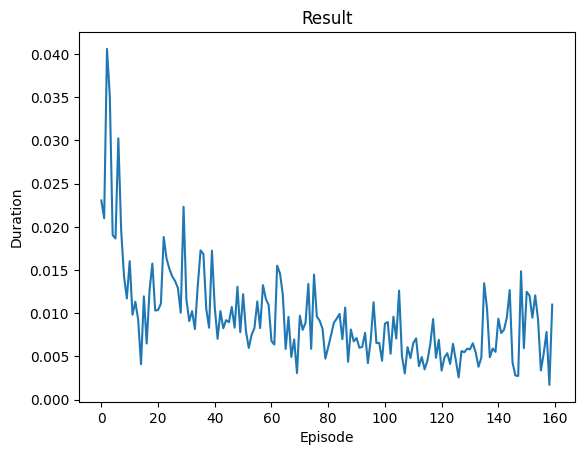

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [155]:
predictor_update_preiod = 10

for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0).permute((0, 3, 1, 2)) # (N, W, H, C) -> (N, D)
    for i_skil_eps in range(skill_eps_count):
        skill = torch.tensor([random.choice([*range(num_skills)])], device=device).unsqueeze(0).repeat(((state.size()[0]), 1)) # [1, 1]
        # skill_state_feature = torch.cat((skill, state_feature), dim=1) # (N, D+1)
        terminal_state = None
        secondary_memory = []
        for t in range(skill_eps_len):
            action = select_action(state, skill)
            observation, _, terminated, truncated, _ = env.step(action.item()) # zero discount? ignore reward
            # reward = nn.functional.softmax(predictor_net()
            done = terminated or truncated
            
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0).permute((0, 3, 1, 2))
            
            if terminated:
                secondary_memory.append((state, action, None, skill))
                state = next_state
                break
            elif truncated:
                secondary_memory.append((state, action, next_state, skill))
                state = next_state
                break
            else:
                secondary_memory.append((state, action, next_state, skill))
                state = next_state

        initial_state = secondary_memory[0][0]
        init_terminal = torch.cat((initial_state, state), dim=1)
        with torch.no_grad():
            reward = prev_predictor_net(init_terminal)[:, skill.item()] - prev_regularizer_net(state)[:, skill.item()]
            # print(reward)
        
        for s, a, ns, sk in secondary_memory:
            memory.push(s, a, ns, sk, reward)
            
        td_error = optimize_model()
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)
        # TODO: parallelizable?
        pred_loss = torch.log(predictor_net(init_terminal))[:, skill.item()]
        reg_loss = torch.log(regularizer_net(state))[:, skill.item()]

        regularizer_optimizer.zero_grad()
        predictor_optimizer.zero_grad()
        pred_loss.backward()
        reg_loss.backward()
        regularizer_optimizer.step()
        predictor_optimizer.step()

        predictor_update_preiod -= 1
        if not predictor_feature_extractor:
            prev_predictor_net.load_state_dict(predictor_net.state_dict())
            prev_regularizer_net.load_state_dict(regularizer_net.state_dict())
            predictor_feature_extractor = 10

        if td_error:
            episode_durations.append(td_error)
            # plot_durations()

        if done:
            # TODO: caution of breaking nested loop
            break
print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()